## Model to check whether label - 0 exists or not

### Import statements

In [1]:
import fastai
print(fastai.__version__)

1.0.28


In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import os
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import scipy.optimize as opt
from sklearn.metrics import f1_score

import math
import cv2
import subprocess
from operator import itemgetter

In [3]:
np.random.seed(42)

In [4]:
path = Path('data')

In [5]:
def fill_targets(row):
    row.Target1 = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        row.loc['Target2'] = 1 if 0 in row.Target1 else 0
    return row

In [6]:
train_df = pd.read_csv(path / 'train.csv')
train_df = train_df.apply(fill_targets, axis=1)
train_df.drop('Target', inplace=True, axis=1)
train_df.rename({'Target2': 'Target'}, axis=1, inplace=True)
train_df.to_csv(path / 'train-0.csv')
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,1
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,1
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,0


In [7]:
tmp = pd.read_csv(path / 'train.csv')
tmp.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


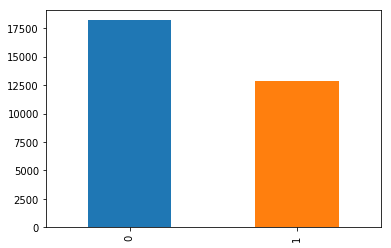

In [8]:
(train_df['Target'].astype(int)).value_counts().plot.bar()

In [9]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [10]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [11]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [12]:
src = (ImageItemList.from_csv(path, 'train-0.csv', folder='train', suffix='.png', cols=1)
      .random_split_by_pct(0.2)
      .label_from_df(cols=2))

In [13]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [14]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [15]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [16]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [17]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [18]:
src.add_test(test_fnames, label='0');

In [19]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [20]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [21]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.,
                             xtra_tfms=[symmetric_warp(magnitude=(-0.2,0.2))])

In [22]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=24).normalize(protein_stats))

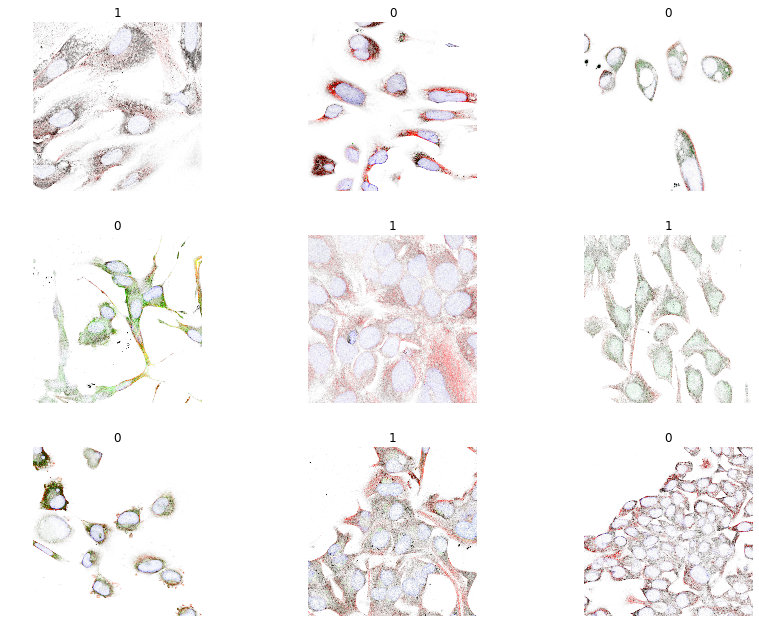

In [23]:
data.show_batch(rows=3, figsize=(12,9))

In [24]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [25]:
def _resnet_split(m): return (m[0][6],m[1])

In [26]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [27]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    path=path,    
    metrics=[accuracy], 
)

# learn = learn.to_fp16()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(2, 2e-2)

Total time: 13:57
epoch  train_loss  valid_loss  accuracy
1      0.439404    0.581674    0.761989  (07:03)
2      0.364748    0.353587    0.842935  (06:54)



In [30]:
learn.fit_one_cycle(6, 1e-4)

Total time: 41:28
epoch  train_loss  valid_loss  accuracy
1      0.339682    0.350728    0.844062  (06:54)
2      0.343800    0.349695    0.845027  (06:54)
3      0.339519    0.348491    0.845993  (06:54)
4      0.336228    0.347180    0.847924  (06:55)
5      0.334708    0.346520    0.848246  (06:54)
6      0.338062    0.346462    0.846315  (06:54)



In [31]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(6, slice(1e-6, 5e-5))

Total time: 41:48
epoch  train_loss  valid_loss  accuracy
1      0.341319    0.346075    0.847119  (07:13)
2      0.330250    0.346612    0.845832  (06:55)
3      0.329952    0.346127    0.847924  (06:54)
4      0.342324    0.346841    0.846798  (06:55)
5      0.334170    0.345927    0.847763  (06:55)
6      0.343011    0.346761    0.845832  (06:54)



In [30]:
learn.save("unfreeze-224-label-0")

In [28]:
learn.load("unfreeze-224-label-0")
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


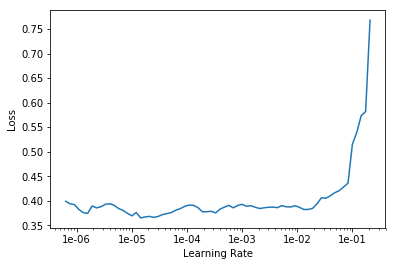

In [32]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(6, 1e-3)

Total time: 2:11:12
epoch  train_loss  valid_loss  accuracy
1      0.374979    0.335887    0.848890  (22:23)
2      0.364156    0.328503    0.853235  (21:48)
3      0.339428    0.323279    0.855488  (21:46)
4      0.328626    0.318200    0.860155  (21:46)
5      0.319168    0.313601    0.859994  (21:44)
6      0.296175    0.316899    0.858706  (21:43)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


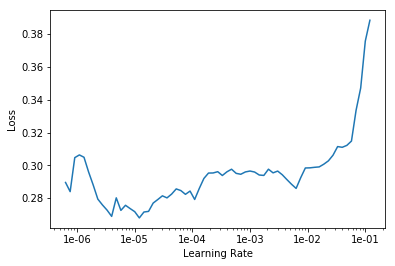

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(6, 1e-6)

Total time: 2:10:28
epoch  train_loss  valid_loss  accuracy
1      0.320688    0.316230    0.859994  (21:44)
2      0.303894    0.314638    0.861764  (21:43)
3      0.316243    0.315736    0.860155  (21:44)
4      0.316401    0.313808    0.859511  (21:45)
5      0.307371    0.314626    0.860798  (21:45)
6      0.295213    0.313792    0.859189  (21:44)



In [32]:
learn.save("freeze-386-label-0")

In [28]:
_ = learn.load("freeze-386-label-0")

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


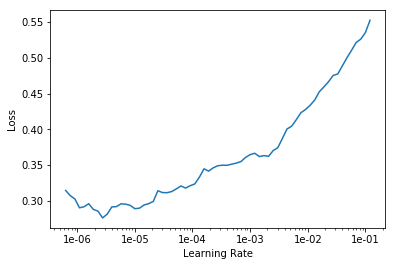

In [34]:
learn.lr_find()
learn.recorder.plot()

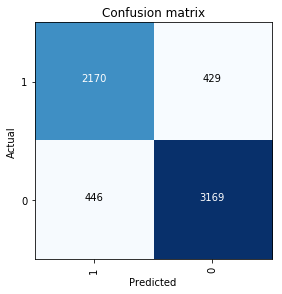

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [30]:
learn.fit_one_cycle(10, slice(1e-8, 1e-6))

Total time: 5:07:03
epoch  train_loss  valid_loss  accuracy
1      0.301532    0.316128    0.860798  (31:31)
2      0.315091    0.321785    0.855809  (30:45)
3      0.315306    0.313241    0.860959  (30:32)
4      0.313958    0.313545    0.861442  (30:33)
5      0.317856    0.314525    0.861442  (30:34)
6      0.312123    0.315783    0.859350  (30:34)
7      0.288483    0.315759    0.860155  (30:35)
8      0.328779    0.313189    0.861120  (30:39)
9      0.299399    0.313633    0.860798  (30:41)
10     0.309258    0.313831    0.860798  (30:35)



In [31]:
learn.save("unfreeze-386-label-0")

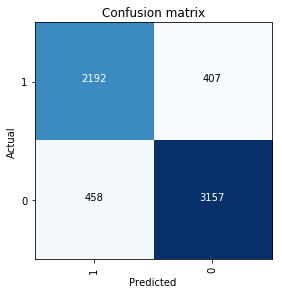

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [28]:
_ = learn.load("unfreeze-386-label-0")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


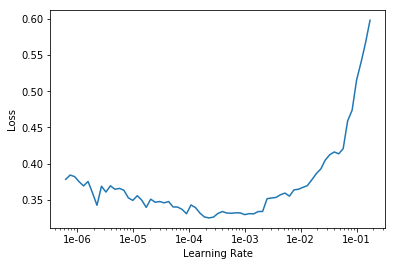

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(8, 3e-5)

Total time: 4:32:19
epoch  train_loss  valid_loss  accuracy
1      0.334478    0.377325    0.836176  (34:27)
2      0.354738    0.371368    0.838108  (34:00)
3      0.341317    0.372111    0.836820  (33:58)
4      0.369015    0.366510    0.837625  (33:57)
5      0.320710    0.355290    0.845832  (33:57)
6      0.327302    0.355957    0.843096  (33:58)
7      0.330354    0.372123    0.836176  (33:59)
8      0.322100    0.355770    0.844545  (34:00)



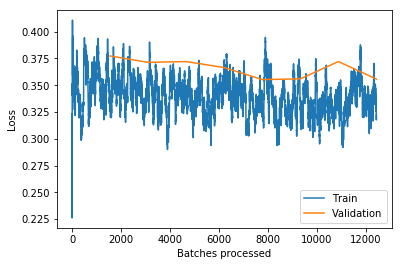

In [31]:
learn.recorder.plot_losses()

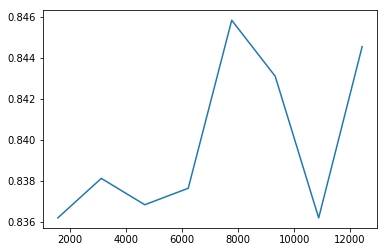

In [32]:
learn.recorder.plot_metrics()

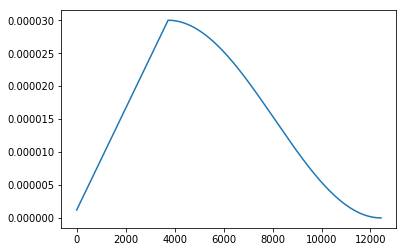

In [33]:
learn.recorder.plot_lr()

In [34]:
learn.save("freeze-512-label-0")

In [28]:
_ = learn.load("freeze-512-label-0")

In [32]:
########################## CURRENTLY HERE

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


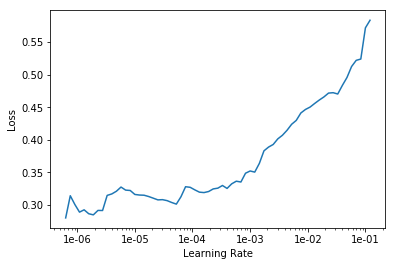

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy


KeyboardInterrupt: 

In [ ]:
learn.save("unfreeze-512-label-0")

In [ ]:
_ = learn.load("unfreeze-512-label-0")

In [ ]:
preds,_ = learn.get_preds(DatasetType.Test)

In [ ]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)


In [ ]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
# df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)
df.head()

In [ ]:
df.to_csv(path / 'focal_loss_gamma_0.25_512_unfreeze-no-tta.csv', header=True, index=False)

In [ ]:
learn.fit_one_cycle(15, max_lr=slice(1e-10, 1e-7))